# Определение перспективного тарифа для телеком-компании

Клиентам федерального оператора мобильной связи предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей оператора мобильной связи: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

*Описание тарифов:*
- Тариф «Смарт»:
  - Ежемесячная плата: 550 рублей;
  - Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика;
  - Стоимость услуг сверх тарифного пакета:
   - минута разговора: 3 рубля;
   - сообщение: 3 рубля;
   - 1 Гб интернет-трафика: 200 рублей.
- Тариф «Ультра»:
  - Ежемесячная плата: 1950 рублей;
  - Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика;
  - Стоимость услуг сверх тарифного пакета:
   - минута разговора: 1 рубль;
   - сообщение: 1 рубль;
   - 1 Гб интернет-трафика: 150 рублей.

*Примечание:*
- оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
- для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

**Цель исследования**: провести исследовательский анализ поведения клиентов и сделать вывод — какой тариф лучше.

## Знакомство с данными

In [1]:
# Импортируем необходимые для исследования библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
# присваиваем имя переменной
df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.info()
df_calls.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [3]:
# присваиваем имя переменной
df_internet = pd.read_csv('/datasets/internet.csv')
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Столбец `Unnamed: 0` не несет никакой смысловой нагрузки, лишь дублирует индекс. Соответственно его сразу можно удалить.

In [4]:
# удалим столбец "Unnamed: 0" из df_internet
df_internet = df_internet.drop('Unnamed: 0', axis=1)

In [5]:
# присваиваем имя переменной
df_messages = pd.read_csv('/datasets/messages.csv')
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [6]:
# присваиваем имя переменной
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_tariffs.info()
df_tariffs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [7]:
# присваиваем имя переменной
df_users = pd.read_csv('/datasets/users.csv')
display(df_users.head(5))
df_users.info()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Описание данных:

Таблица `df_users` (информация о пользователях):
- `user_id` — уникальный идентификатор пользователя;
- `first_name` — имя пользователя;
- `last_name` — фамилия пользователя;
- `age` — возраст пользователя (годы);
- `reg_date` — дата подключения тарифа (день, месяц, год);
- `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных);
- `city` — город проживания пользователя;
- `tariff` — название тарифного плана.

Таблица `df_calls` (информация о звонках):
- `id` — уникальный номер звонка;
- `call_date` — дата звонка;
- `duration` — длительность звонка в минутах;
- `user_id` — идентификатор пользователя, сделавшего звонок.

Таблица `df_messages` (информация о сообщениях):
- `id` — уникальный номер сообщения;
- `message_date` — дата сообщения;
- `user_id` — идентификатор пользователя, отправившего сообщение;

Таблица `df_internet` (информация об интернет-сессиях):
- `id` — уникальный номер сессии;
- `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах);
- `session_date` — дата интернет-сессии;
- `user_id` — идентификатор пользователя;

Таблица `df_tariffs` (информация о тарифах):
- `tariff_name` — название тарифа;
- `rub_monthly_fee` — ежемесячная абонентская плата в рублях;
- `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату;
- `messages_included` — количество сообщений в месяц, включённых в абонентскую плату;
- `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах);
- `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата);
- `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета;
- `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

Вывод:
- из таблицы "df_internet" удалим столбец "Unnamed: 0", т.к. он лишь дублирует индекс (выполнено);
- необходимо изменить тип данных в столбцах с датой в 4х таблицах: df_calls, df_internet, df_messages, df_users. Заменить их тип данных с "object" на "datetime64[M]". К типам остальных столбцов замечаний нет;
- длительность звонка необходимо округлить вверх до целого, как сказано в примечании к проекту, применив np.ceil.

## Предобработка данных

### Приведение к нужным типам и нахождение ошибок в данных

In [8]:
# округлим длительность звонка вверх до целого, как сказано в примечании к проекту, применив np.ceil
df_calls['duration'] = df_calls['duration'].apply(np.ceil)

In [9]:
# применим метод astype('datetime64[M]') для изменения типа данных в дате
# удобство использования данного метода в том, что не нужно обращаться к pd.DatetimeIndex
df_calls['call_date'] = df_calls['call_date'].astype('datetime64[M]')
df_internet['session_date'] = df_internet['session_date'].astype('datetime64[M]')
df_messages['message_date'] = df_messages['message_date'].astype('datetime64[M]')
df_users['reg_date'] = df_users['reg_date'].astype('datetime64[M]')

Вероятно, что нули в столбцах "длительность звонка в минутах" и "объём потраченного за сессию интернет-трафика (в мегабайтах)" это пропущенные звонки и ошибочные сессии. Их удалять не будем, так как они "схлопнутся", когда мы перейдем к этапу группировки данных.

### Подготовка пользовательских данных

In [10]:
# добавим в датафреймы столбцы с номером месяца
df_calls['month'] = df_calls['call_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month
df_users['month'] = df_users['reg_date'].dt.month

In [11]:
# расчет количества звонков и израсходованных минут по месяцам
df_calls_count = df_calls.groupby(['user_id', 'month']).agg({'duration':['sum','count']})
df_calls_count.head()

duration      
                   sum count
user_id month               
1000    5        159.0    22
        6        172.0    43
        7        340.0    47
        8        408.0    52
        9        466.0    58

In [12]:
# применим группировку и соберем фрейм для дальнейшего анализа
df_calls = (
    df_calls.groupby(['user_id', 'month'])
    .agg({'duration':'sum'})
    .reset_index()
)
df_internet = (
    df_internet.groupby(['user_id', 'month'])
    .agg({'mb_used': 'sum'})
    .reset_index()
)
df_messages = (
    df_messages.groupby(['user_id', 'month'])
    .agg({'id': 'count'})
    .rename(columns = {'id': 'messages'})
    .reset_index()
)

# объединим таблицы
report = df_calls.merge(
    df_internet,
    on = ['user_id', 'month'],
    how = 'outer'
).merge(
    df_messages,
    on = ['user_id', 'month'],
    how = 'outer'
).fillna(0)

report = report.merge(
    df_users,
    on = 'user_id',
    how = 'left'
).merge(
    df_tariffs,
    left_on = 'tariff',
    right_on = 'tariff_name',
    how = 'left'
).reset_index()

report = report.drop('month_y', axis=1)
report.rename(columns = {'month_x':'month'}, inplace = True)

# добавим столбец с расчетом округления мегабайт до гигабайт
report['gb_used'] = (report['mb_used'] / 1024).apply(np.ceil)
report.head()

,index,user_id,month,duration,mb_used,messages,age,churn_date,city,first_name,...,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used
0,0,1000,5,159.0,2253.49,22.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,3.0
1,1,1000,6,172.0,23233.77,60.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,23.0
2,2,1000,7,340.0,14003.64,75.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,14.0
3,3,1000,8,408.0,14055.93,81.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,14.0
4,4,1000,9,466.0,14568.91,57.0,52,NaN,Краснодар,Рафаил,...,ultra,1000,30720,3000,1950,150,1,1,ultra,15.0


In [13]:
# применим функцию для расчета выручки с каждого пользователя
def revenue(row):
    minutes_over = (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    messages_over = (row['messages'] - row['messages_included']) * row['rub_per_message'] 
    traffic_over = (row['gb_used'] - (row['mb_per_month_included']/1024)) * row['rub_per_gb']
    rub_monthly_fee = row['rub_monthly_fee']
    if minutes_over < 0:
        minutes_over = 0
    if messages_over < 0: 
        messages_over = 0 
    if traffic_over < 0: 
        traffic_over = 0
    return minutes_over + messages_over + traffic_over + rub_monthly_fee
report['revenue'] = report.apply(revenue, axis=1)
report

,index,user_id,month,duration,mb_used,messages,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,gb_used,revenue
0,0,1000,5,159.0,2253.49,22.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,ultra,3.0,1950.0
1,1,1000,6,172.0,23233.77,60.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,ultra,23.0,1950.0
2,2,1000,7,340.0,14003.64,75.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,ultra,14.0,1950.0
3,3,1000,8,408.0,14055.93,81.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,ultra,14.0,1950.0
4,4,1000,9,466.0,14568.91,57.0,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,ultra,15.0,1950.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,3209,1489,8,0.0,11050.56,17.0,35,NaN,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,smart,11.0,550.0
3210,3210,1489,9,0.0,17206.30,32.0,35,NaN,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,smart,17.0,950.0
3211,3211,1489,10,0.0,19559.44,21.0,35,NaN,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,smart,20.0,1550.0
3212,3212,1489,11,0.0,17491.56,20.0,35,NaN,Санкт-Петербург,Павел,...,50,15360,500,550,200,3,3,smart,18.0,1150.0


In [14]:
report.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   index                  3214 non-null   int64         
 1   user_id                3214 non-null   int64         
 2   month                  3214 non-null   int64         
 3   duration               3214 non-null   float64       
 4   mb_used                3214 non-null   float64       
 5   messages               3214 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    object        
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

Пользовательские данные подготовленны. Приступим к исследовательскому анализу.

## Исследовательский анализ данных

In [15]:
# создадим отдельные датафреймы по тарифному плану, для удобства
report_smart = report.loc[report['tariff_name'] == 'smart']
report_ultra = report.loc[report['tariff_name'] == 'ultra']

In [16]:
# сгруппируем таблицу со средними значениями в каждом месяце по тарифу "Smart"
report_smart_month = report_smart.groupby('month')['duration', 'messages', 'gb_used', 'revenue'].mean()
display(report_smart_month)

,duration,messages,gb_used,revenue
month,,,,
1,203.852941,18.235294,8.735294,721.323529
2,298.689655,24.086207,11.844828,827.603448
3,390.051948,31.857143,15.233766,1164.623377
4,367.133929,30.741071,13.625000,963.089286
5,387.361702,33.773050,15.907801,1197.510638
6,395.640244,33.402439,15.951220,1204.018293
7,408.353234,33.751244,15.875622,1223.950249
8,421.468085,33.638298,16.736170,1320.595745
9,428.611538,33.638462,16.392308,1249.946154


In [17]:
# сгруппируем таблицу со средними значениями в каждом месяце по тарифу "Ultra"
report_ultra_month = report_ultra.groupby('month')['duration', 'messages', 'gb_used', 'revenue'].mean()
display(report_ultra_month)

,duration,messages,gb_used,revenue
month,,,,
1,428.111111,33.777778,13.222222,1950.000000
2,297.125000,21.958333,12.000000,1975.000000
3,489.648649,32.297297,17.648649,2014.864865
4,458.018182,31.563636,16.963636,2001.818182
5,510.328358,37.850746,19.373134,2059.701493
6,479.702381,41.726190,18.940476,2039.285714
7,545.791209,49.846154,20.505495,2118.131868
8,510.775701,48.439252,19.598131,2083.177570
9,539.443478,52.286957,19.243478,2024.347826


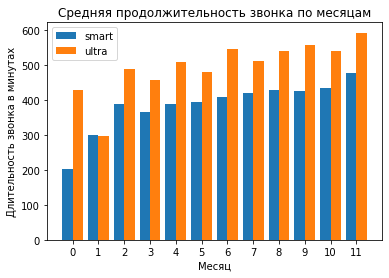

In [18]:
# построим столбчатую диаграмму по средней продолжительности звонка в каждом месяце, с разбивкой по тарифам
month = [f"{i}" for i in range(12)]
g1 = report_smart_month['duration'] 
g2 = report_ultra_month['duration']
width = 0.4
x = np.arange(len(month))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='smart')
rects2 = ax.bar(x + width/2, g2, width, label='ultra')
ax.set_title('Средняя продолжительность звонка по месяцам')
ax.set_xticks(x)
ax.set_xticklabels(month)
ax.legend()
plt.ylabel('Длительность звонка в минутах')
plt.xlabel('Месяц')
plt.show()

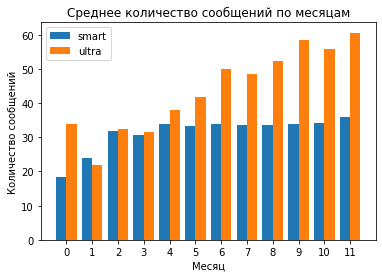

In [19]:
# построим столбчатую диаграмму по среднему количеству сообщений в каждом месяце, с разбивкой по тарифам
month = [f"{i}" for i in range(12)]
g1 = report_smart_month['messages'] 
g2 = report_ultra_month['messages']
width = 0.4
x = np.arange(len(month))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='smart')
rects2 = ax.bar(x + width/2, g2, width, label='ultra')
ax.set_title('Среднее количество сообщений по месяцам')
ax.set_xticks(x)
ax.set_xticklabels(month)
ax.legend()
plt.ylabel('Количество сообщений')
plt.xlabel('Месяц')
plt.show()

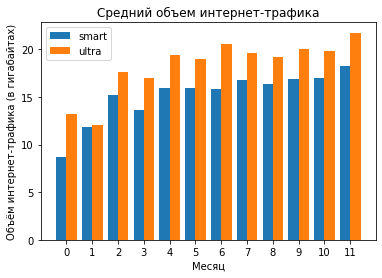

In [20]:
# построим столбчатую диаграмму по среднему объему трафика в каждом месяце, с разбивкой по тарифам
month = [f"{i}" for i in range(12)]
g1 = report_smart_month['gb_used'] 
g2 = report_ultra_month['gb_used']
width = 0.4
x = np.arange(len(month))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='smart')
rects2 = ax.bar(x + width/2, g2, width, label='ultra')
ax.set_title('Средний объем интернет-трафика')
ax.set_xticks(x)
ax.set_xticklabels(month)
ax.legend()
plt.ylabel('Объём интернет-трафика (в гигабайтах)')
plt.xlabel('Месяц')
plt.show()

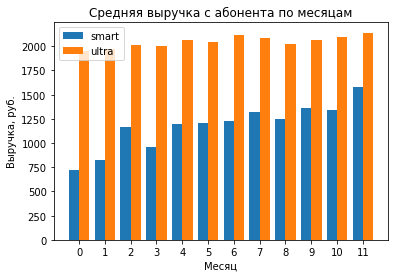

In [21]:
# построим столбчатую диаграмму по средней продолжительности звонка в каждом месяце, с разбивкой по тарифам
month = [f"{i}" for i in range(12)]
g1 = report_smart_month['revenue'] 
g2 = report_ultra_month['revenue']
width = 0.4
x = np.arange(len(month))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='smart')
rects2 = ax.bar(x + width/2, g2, width, label='ultra')
ax.set_title('Средняя выручка с абонента по месяцам')
ax.set_xticks(x)
ax.set_xticklabels(month)
ax.legend()
plt.ylabel('Выручка, руб.')
plt.xlabel('Месяц')
plt.show()

По столбчатым диаграммам видно, что пользователи "Мегалайн" в течение года увеличивают потребление по всем параметрам обоих тарифов, от начала к концу года. Что касается средней выручки с абонентов, то по тарифу "Ультра" каждый абонент стабильно приносит около 2000 руб. в месяц, на протяжении всего года. Абоненты по тарифу "Смарт", увеличивая свое потребление, увеличивают среднюю выручку на протяжении всего года.

In [22]:
#разделим клиентов по тарифам и определим их поведение 
clients_smart_metrics = report_smart[['duration', 'messages', 'mb_used']] 
print('Тариф "Смарт":')
display(clients_smart_metrics.describe()) 
print('      Длительность звонка в минутах|', 'Дисперсия:', np.var(clients_smart_metrics['duration']), '|',
      'Стандартное отклонение:', np.std(clients_smart_metrics['duration']))
print('               Количество сообщений|', 'Дисперсия:', np.var(clients_smart_metrics['messages']), ' |',
      'Стандартное отклонение:', np.std(clients_smart_metrics['messages']))
print('Объём потраченного интернет-трафика|', 'Дисперсия:', np.var(clients_smart_metrics['mb_used']), '|',
      'Стандартное отклонение:', np.std(clients_smart_metrics['mb_used']))
print('--------------------------------------------------------------------------------------------------------------')

print()
print('Тариф "Ультра":')
clients_ultra_metrics = report_ultra[['duration', 'messages', 'mb_used']] 
display(clients_ultra_metrics.describe()) 
print('      Длительность звонка в минутах|', 'Дисперсия:', np.var(clients_ultra_metrics['duration']), ' |',
      'Стандартное отклонение:', np.std(clients_ultra_metrics['duration']))
print('               Количество сообщений|', 'Дисперсия:', np.var(clients_ultra_metrics['messages']), ' |', 
      'Стандартное отклонение:', np.std(clients_ultra_metrics['messages']))
print('Объём потраченного интернет-трафика|','Дисперсия:',np.var(clients_ultra_metrics['mb_used']),'|',
      'Стандартное отклонение:', np.std(clients_ultra_metrics['mb_used']))

Тариф "Смарт":


,duration,messages,mb_used
count,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16208.386990
std,190.313730,28.227876,5870.476681
min,0.000000,0.000000,0.000000
25%,282.000000,10.000000,12643.010000
50%,422.000000,28.000000,16506.840000
75%,545.000000,51.000000,20042.930000
max,1435.000000,143.000000,38552.450000


      Длительность звонка в минутах| Дисперсия: 36203.06665209469 | Стандартное отклонение: 190.27103471651876
               Количество сообщений| Дисперсия: 796.455482917076  | Стандартное отклонение: 28.221542886898938
Объём потраченного интернет-трафика| Дисперсия: 34447035.49528493 | Стандартное отклонение: 5869.159692433401
--------------------------------------------------------------------------------------------------------------

Тариф "Ультра":


,duration,messages,mb_used
count,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19468.805208
std,317.606098,47.804457,10087.170752
min,0.000000,0.000000,0.000000
25%,284.000000,6.000000,11770.260000
50%,518.000000,38.000000,19308.010000
75%,752.000000,79.000000,26837.690000
max,1673.000000,224.000000,49745.690000


      Длительность звонка в минутах| Дисперсия: 100771.2236172022  | Стандартное отклонение: 317.44483554974113
               Количество сообщений| Дисперсия: 2282.946075394882  | Стандартное отклонение: 47.78018496610161
Объём потраченного интернет-трафика| Дисперсия: 101647713.26174639 | Стандартное отклонение: 10082.049060669482


## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Сформулируем нулевую и альтернативную гипотезу:

- H₀ - средняя выручка пользователей тарифов "Ультра" и "Смарт" равны;
- H₁ - средняя выручка пользователей тарифов "Ультра" и "Смарт" не равны.
 

In [23]:
# применим метод метод st.ttest_ind для проверки гипотезы о равенстве среднего
# двух генеральных совокупностей по взятым из них выборкам
alpha = .05
results = st.ttest_ind(report_smart['revenue'], report_ultra['revenue'])
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Средняя выручка пользователей разных тарифов не равна.

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

Сформулируем нулевую и альтернативную гипотезу:

- H₀ - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;
- H₁ - средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [24]:
# создадим отдельные датафреймы по тарифному плану, для удобства
report_moscow = report[report['city'] == 'Москва']
report_no_moscow = report[report['city'] != 'Москва']

# применим метод метод st.ttest_ind для проверки гипотезы о равенстве среднего
# двух генеральных совокупностей по взятым из них выборкам
alpha = .05 
results = st.ttest_ind(report_moscow['revenue'], report_no_moscow['revenue'])
print('p-значение:', results.pvalue) 
if results.pvalue < alpha: 
    print('Отвергаем нулевую гипотезу') 
else:
    print('Не отвергаем нулевую гипотезу') 

p-значение: 0.5440152911670224
Не отвергаем нулевую гипотезу


Средняя выручка пользователей из Москвы отличается от пользователей других регионов.

## Общий вывод

Задачей исследования был анализ поведения клиентов по которому можно сделать вывод — какой тариф лучше.

На основании проведенного исследования можно сделать следующие выводы:

- пользователи тарифа "Смарт" приносят меньшую выручку компании "Мегалайн", это логично и можно было предвидеть и без столбчатых диаграмм, т.к. стоимость тарифа изначально ниже тарифа "Ультра". Но по столбчатым диаграммам в 3 разделе исследования видно, что динамика тарифа "Смарт" более равномерная и на наш взгляд, более стабильная (нет скачков вверх/вниз от месяца к месяцу). Соответственно, если увеличить количество клиентов привлекая их посредством увеличения рекламного бюджета на данный тариф, прогнозная выручка будет более предсказуемая, чем по тарифу "Ултра".
- средняя выручка пользователей из Москвы отличается от пользователей других регионов, она выше. Соответственно можно сделать вывод, что в регионах есть куда расти.